# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [116]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [117]:
# Load data
df = pd.read_csv('OnlineRetail2.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [118]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [119]:
df.shape

(541909, 8)

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [120]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


Then we could do some descriptive statistic.

In [122]:
# Simple descriptive statistic
# Jika menggunakan exclude object, maka 'Cutsomer_ID' akan terbawa

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


* terdapat anomali pada quantity, mengapa bisa ada quantity minus

Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [123]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


* karena jumlah anomali data masih cukup kecil, remove saja

Then just remove those anomaly data

In [124]:
# Remove anomaly / outliers
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [125]:
df[df['Quantity']== 80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom


Now we're good to go. Lets do some data exploration!

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [127]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

In [128]:
uniqe_check = df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']]

In [129]:
uniqe_check.columns

Index(['InvoiceNo', 'StockCode', 'CustomerID', 'Country'], dtype='object')

In [130]:
unique_check = df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']]

for i in (unique_check.columns):
    x = df[i].nunique()
    print('number of unique value column',i,':',x)

number of unique value column InvoiceNo : 18532
number of unique value column StockCode : 3665
number of unique value column CustomerID : 4338
number of unique value column Country : 37


There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

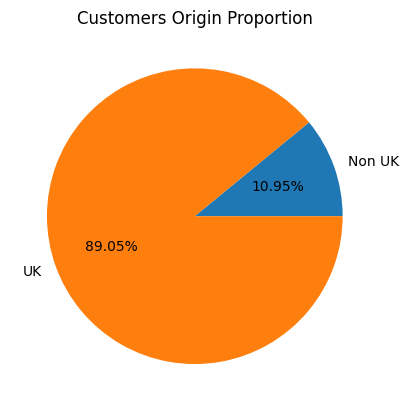

In [131]:
# Simplify country origin (Pie chart untuk melihat komposisi negara)
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK') # ini new column
# Ketika value = UK (true) maka 'UK', ketika (False) maka 'Non' UK

customers_origin = df.groupby(['Country_isUK']).size()
#.size() return number of element 

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [132]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice'] # new column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [133]:
import matplotlib.dates as mdates

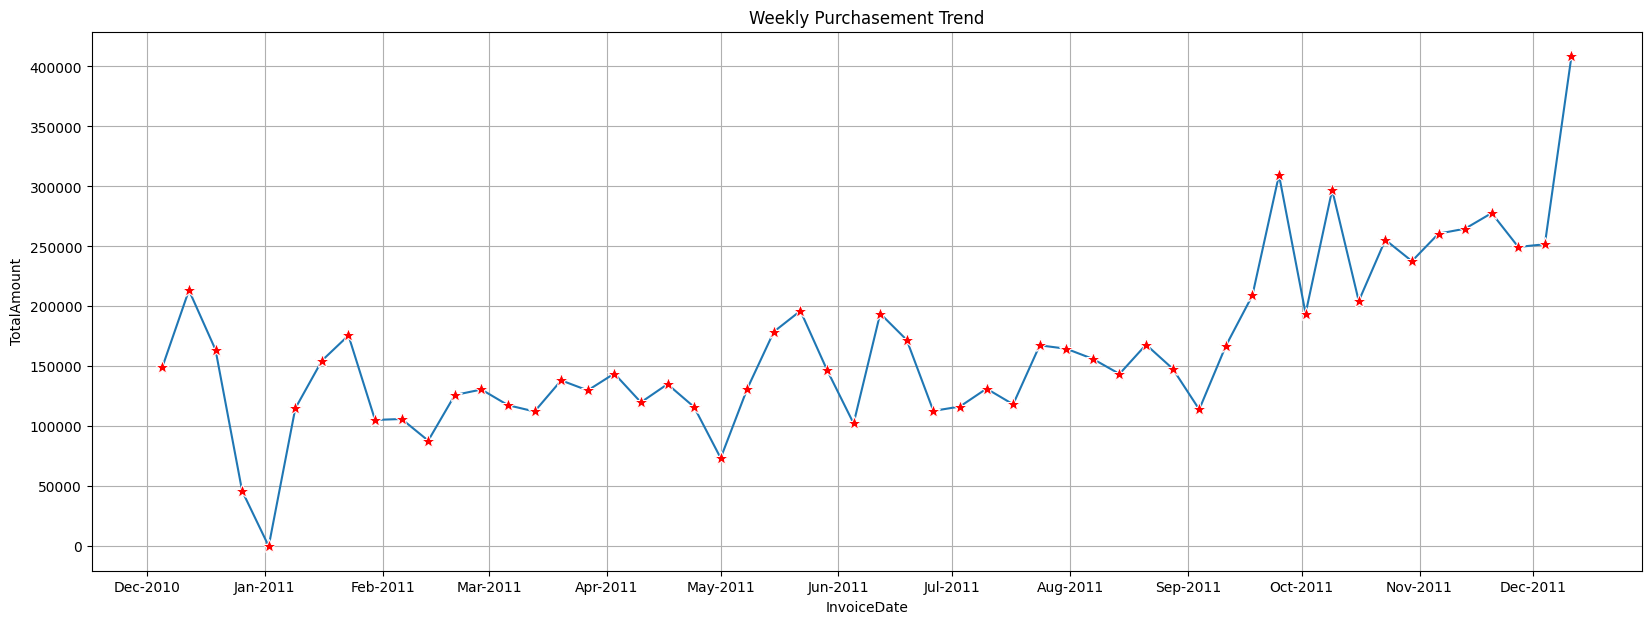

In [134]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()
# pd.Grouper digunakan untuk melakukan aggregating data berdasarkan waktu yang spesifik
# pd.Grouper biasa digunakan didalam function group by
    # key kolom spesifik yang digunakan untuk group by
    # freq : frekuensi dari key -> misal : '1W'

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

* Setiap melakukan analisa trend, wajib untuk memeriksa kenapa ada penurunan atau kenaikan drastis? sekiranya apa penyebabnya?

In [135]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

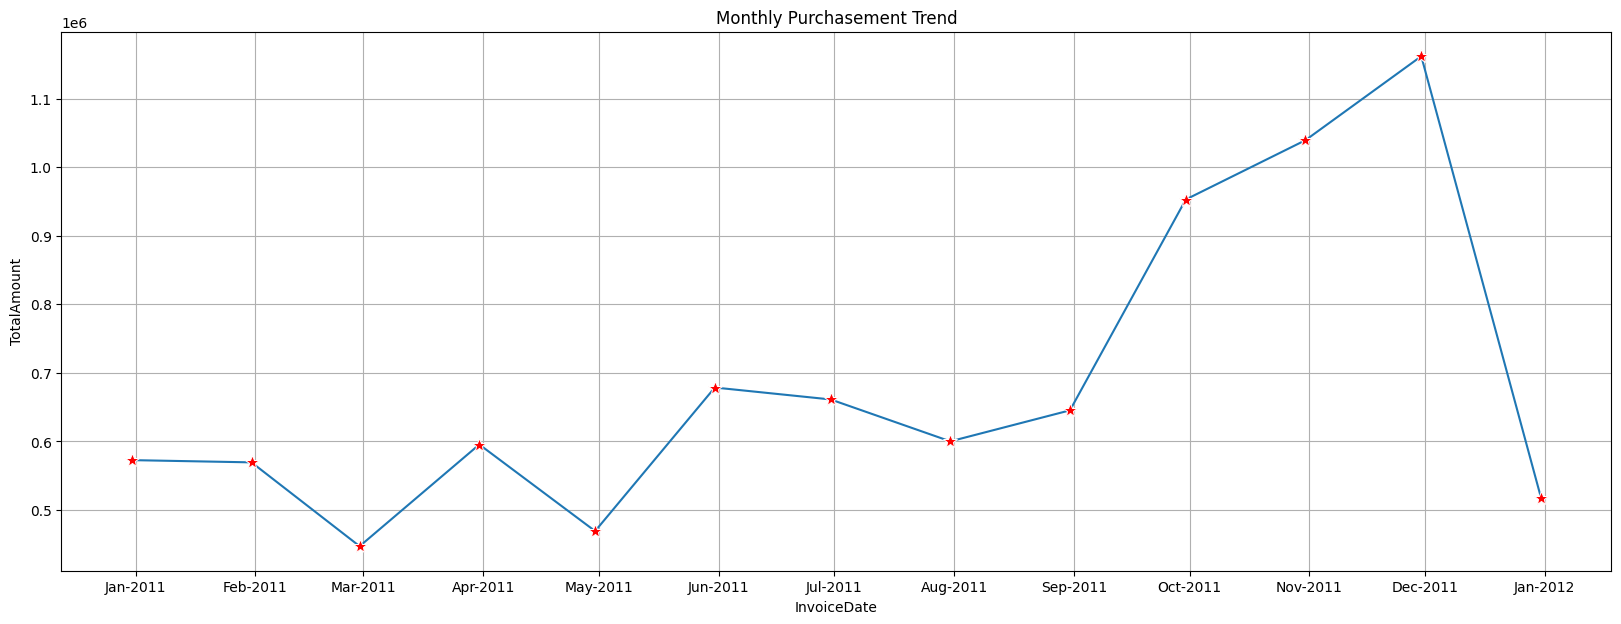

In [136]:

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

In [137]:
df['CustomerID'].duplicated().sum()

np.int64(393546)

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [138]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max() #Recently customer transaction
# Create new dataframe grouping by 'Customer ID', kemudian masukan 'Invoice Date' paling akhir (max)
# tidak mungkin duplikat, karena diambil invoice date yang paling akhir (mungkin dari sekian banyak Invoice Date pada masing -masing Cust.ID)
recency = max(recency) - recency
# max recency = tanggal terakhir transaksi -> diambil dari invoice date paling akhir cust.id
# recency = tanggal terakhir dari masing-masing cust.id
recency = recency.dt.days
recency = recency.rename('Recency')
recency.head()



CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

In [139]:
df_january = df['TotalAmount']

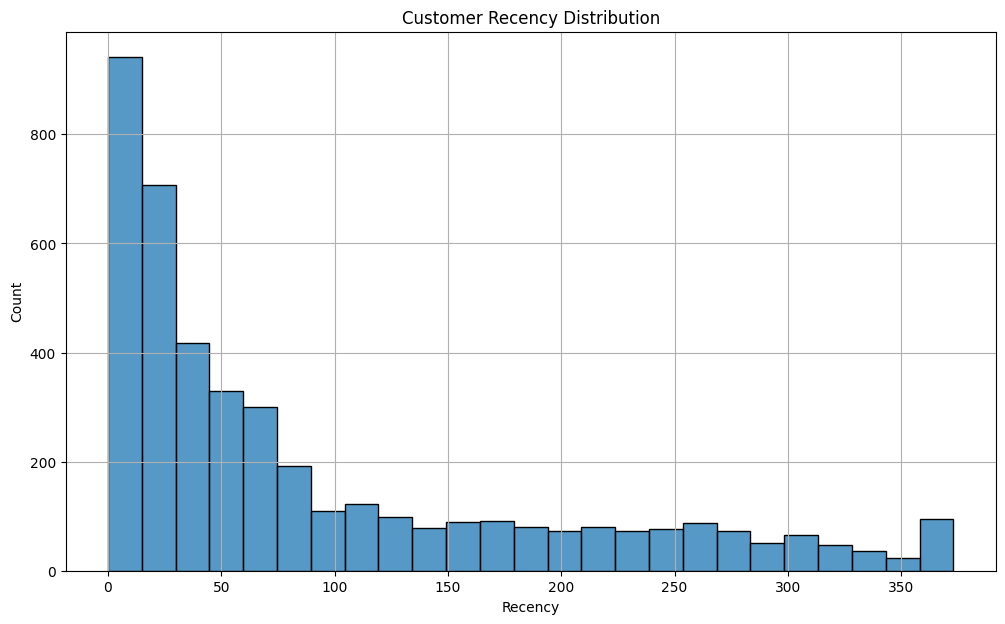

In [140]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [141]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

* Cust ID 12347 dapat dibilang sebagai pelanggan loyal -> apakah perlu untuk diberikan perlakuan khusus?

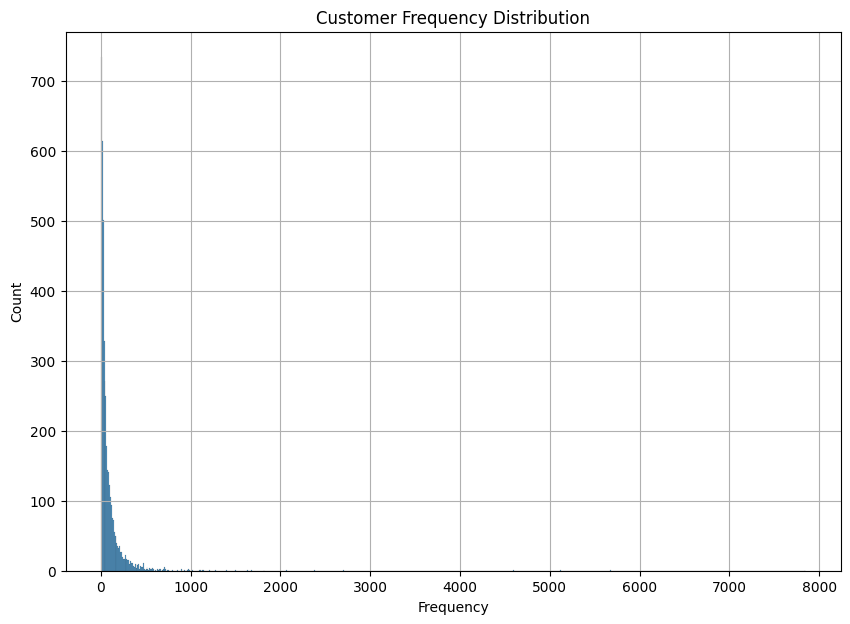

In [142]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [143]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

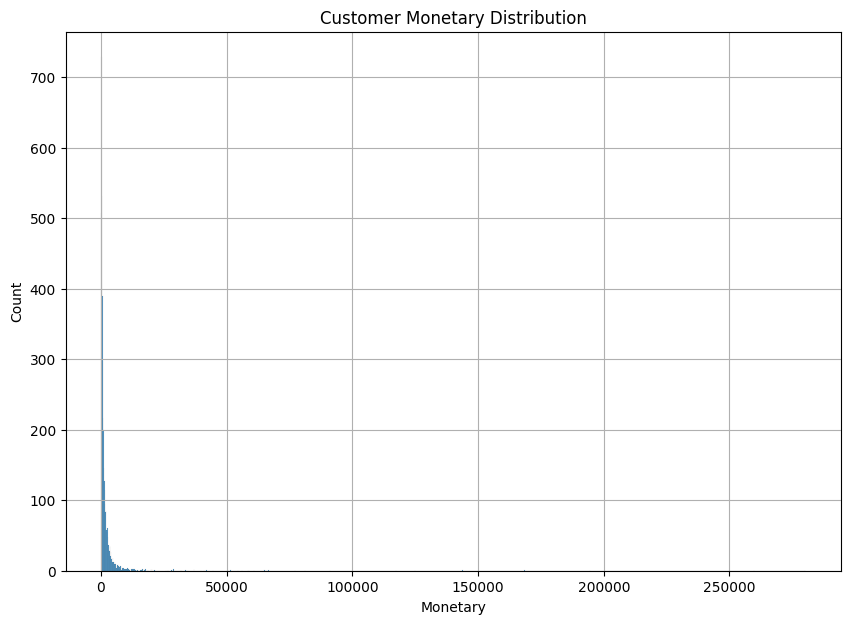

In [144]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

* diperlukan scaling, karena terdapat data yang timpang

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [145]:
df[df['CustomerID'] == 12347].count()

InvoiceNo       182
StockCode       182
Description     182
Quantity        182
InvoiceDate     182
UnitPrice       182
CustomerID      182
Country         182
Country_isUK    182
TotalAmount     182
dtype: int64

In [146]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size() # size() ini mengembalikan nilai berupa berapa banyak Customer ID & Country_isUK di samping muncul
    .reset_index() # convert step sebelumnya ke sebuah data frame dengan mereset indexnya dan menjadi kolom baru
    .drop(0, axis=1) # yang hilang kolom yang terbuat dari .size() ? -> mungkin karena 2 kolom pertama adalah bagian dari group by?
)
country.head()


,CustomerID,Country_isUK
0,12346.0,UK
1,12347.0,Non UK
2,12348.0,Non UK
3,12349.0,Non UK
4,12350.0,Non UK


In [147]:
# Merge the data
df_new = ( country.merge(recency, on = 'CustomerID')\
          .merge(frequency, on = 'CustomerID')\
          .merge(monetary, on = 'CustomerID')
) # menggunakan (\) untuk menandakan masih jadi 1 kode yang sama

# Set CustomerID as index
df_new = df_new.set_index('CustomerID') # mengubah customer ID sebagai index
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [148]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,True
12347.0,1,182,4310.00,False
12348.0,74,31,1797.24,False
12349.0,18,73,1757.55,False
12350.0,309,17,334.40,False


### Scaling

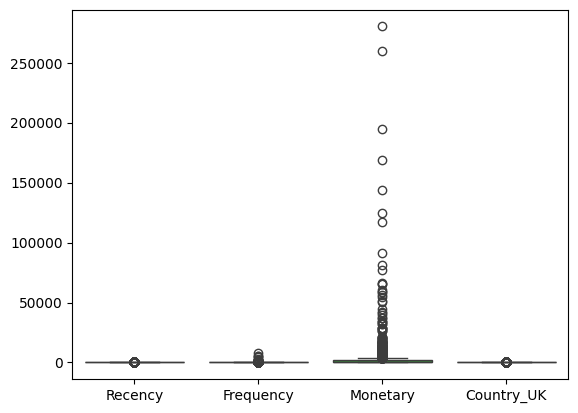

In [149]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [150]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index # Customer ID disini sebagai index bukan sebagai kolom lagi
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


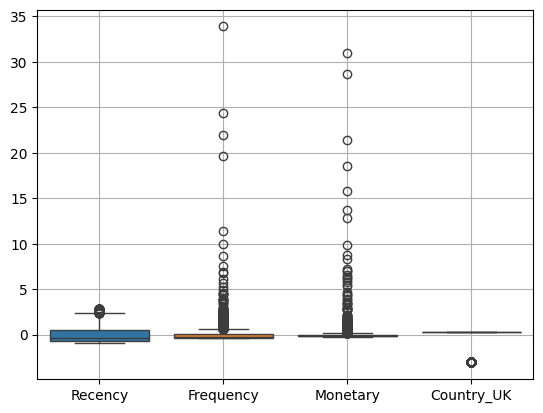

In [151]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

* Seperti ini masih OK

## Modeling

In [152]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [153]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10] # mau berapa cluster yang dibentuk?
silhouette = []

# algoritma akan mengecek masing-masing K berdasarkan shiluette

for k in (possible_k):
    kmeans = KMeans(n_clusters=k, random_state=123).fit(df_scaled)
    silhouette.append(silhouette_score(X = df_scaled, labels=kmeans.labels_))

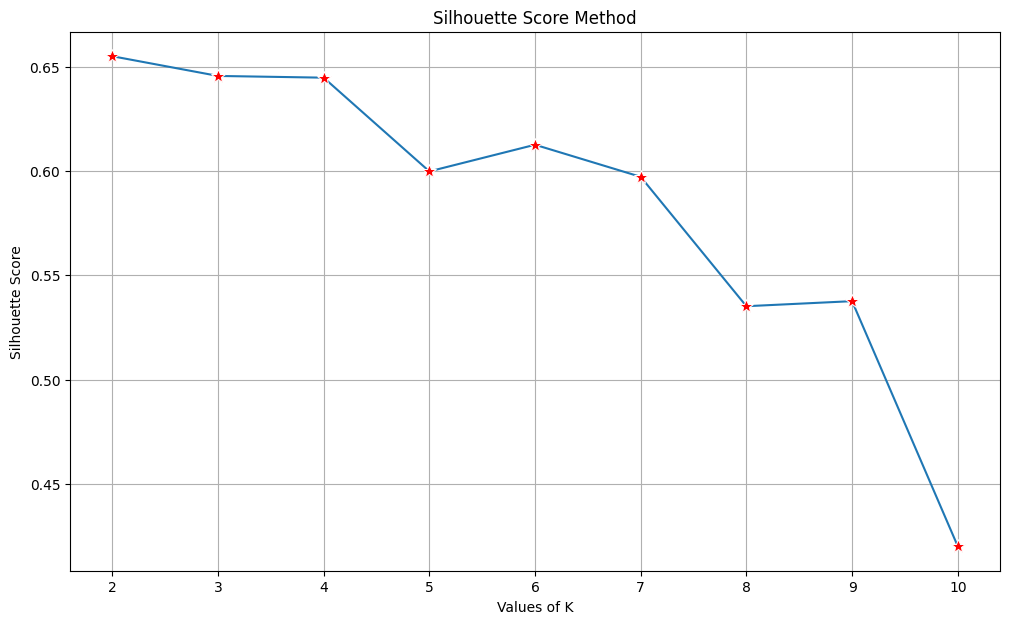

In [154]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2, take 5 for comparison

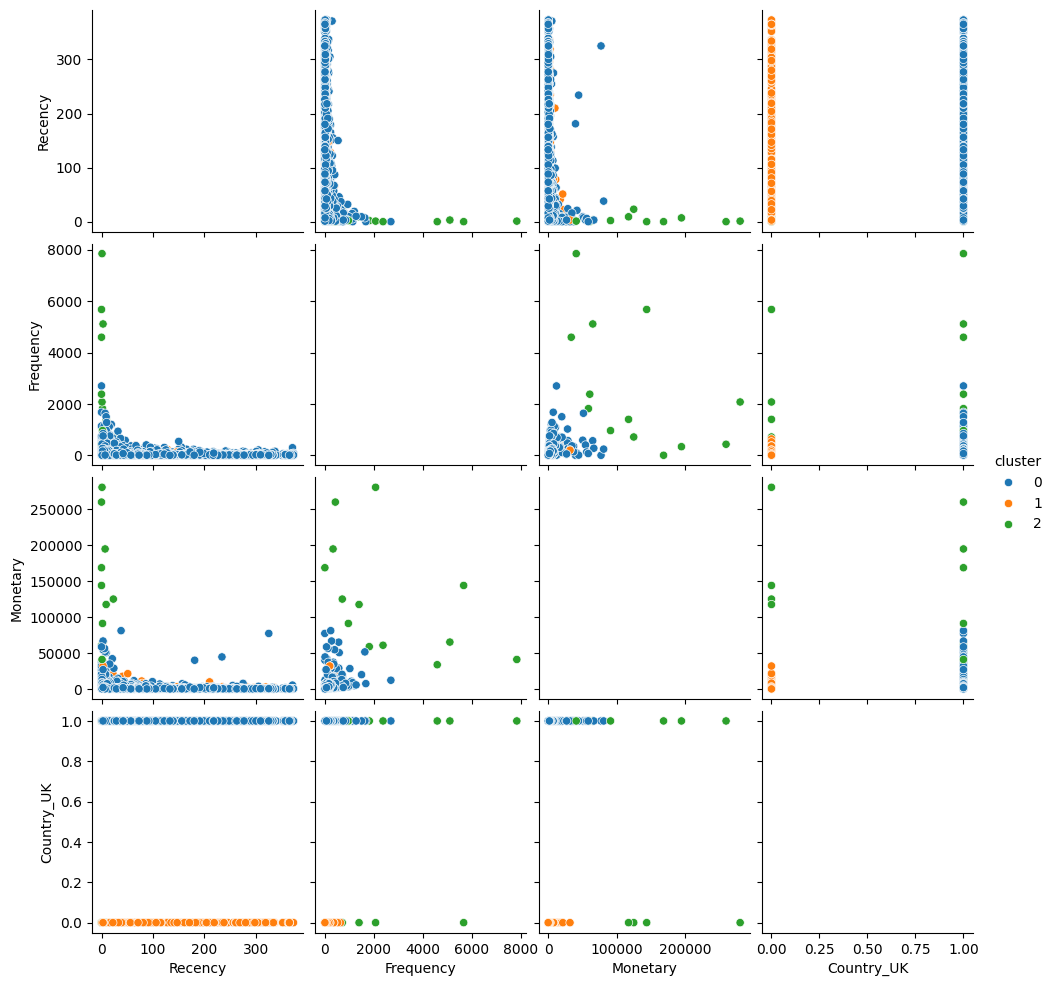

In [155]:
#Pairplot
kmeans = KMeans(n_clusters=3,random_state=123).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_
# akan dibuat kolom baru dengan nama 'cluster' dimana isinya merupakan hasil dari clustering berdasarkan K-Means

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [156]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['count','mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0             1              2
Recency   count    3911.000000    414.000000      13.000000
          mean       91.418819     95.405797       3.692308
          std        99.555506    104.638705       6.459936
          min         0.000000      0.000000       0.000000
          q25        17.000000     18.000000       0.000000
          median     50.000000     52.000000       1.000000
          q75       142.000000    136.500000       3.000000
          max       373.000000    373.000000      23.000000
Frequency count    3911.000000    414.000000      13.000000
          mean       84.591409     81.396135    2565.307692
          std       134.712410     96.304061    2456.928617
          min         1.000000      1.000000       3.000000
          q25        17.000000     21.250000     714.000000
          median     41.000000     45.000000    1818.000000
          q75        99.000000    101.000000    4595.000000
          max      2700.000000    638.000000    7847.000000
Monetary  count    3911.000000    414.000000      13.000000
          mean     1619.836043   2262.538913  126118.310000
          std      4128.197685   3479.689136   80607.677360
          min         3.750000     51.560000   33719.730000
          q25       299.810000    459.650000   60767.900000
          median    650.410000   1025.700000  117379.630000
          q75      1567.065000   2659.962500  168472.500000
          max     81024.840000  31906.820000  280206.020000

In [157]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        True          3911
1        False          414
2        False            4
         True             9
Name: Recency, dtype: int64

In [158]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        True          3911
1        False          414
2        False            4
         True             9
Name: Frequency, dtype: int64

In [159]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary"].count()

cluster  Country_UK
0        True          3911
1        False          414
2        False            4
         True             9
Name: Monetary, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

# Jawaban Question 1

## A

In [160]:
# Siapa TOP 5 Customer dengan pembelian terbanyak
top_5 = df_new.groupby('CustomerID')['Monetary'].sum()
check_top_5 = top_5.sort_values(ascending= False).head(5).index.tolist()
check_top_5

print('there are top 5 customer with the most spending :')
for i in (check_top_5):
    print(i)

there are top 5 customer with the most spending :
14646.0
18102.0
17450.0
16446.0
14911.0


## B

In [161]:
# Create total amount by month
by_month = df.groupby(
   by = pd.Grouper(key='InvoiceDate', freq='M')).aggregate({'TotalAmount' : 'sum'})

# Change time stamp to 'Month'
by_month.index = by_month.index.strftime('%B %Y')

top_5_month = by_month.sort_values(by='TotalAmount',ascending= False).head(5).index.tolist()

print('there are top 5 month with the higher Total Amount :')
for i in (top_5_month):
    print(i)

there are top 5 month with the higher Total Amount :
November 2011
October 2011
September 2011
May 2011
June 2011


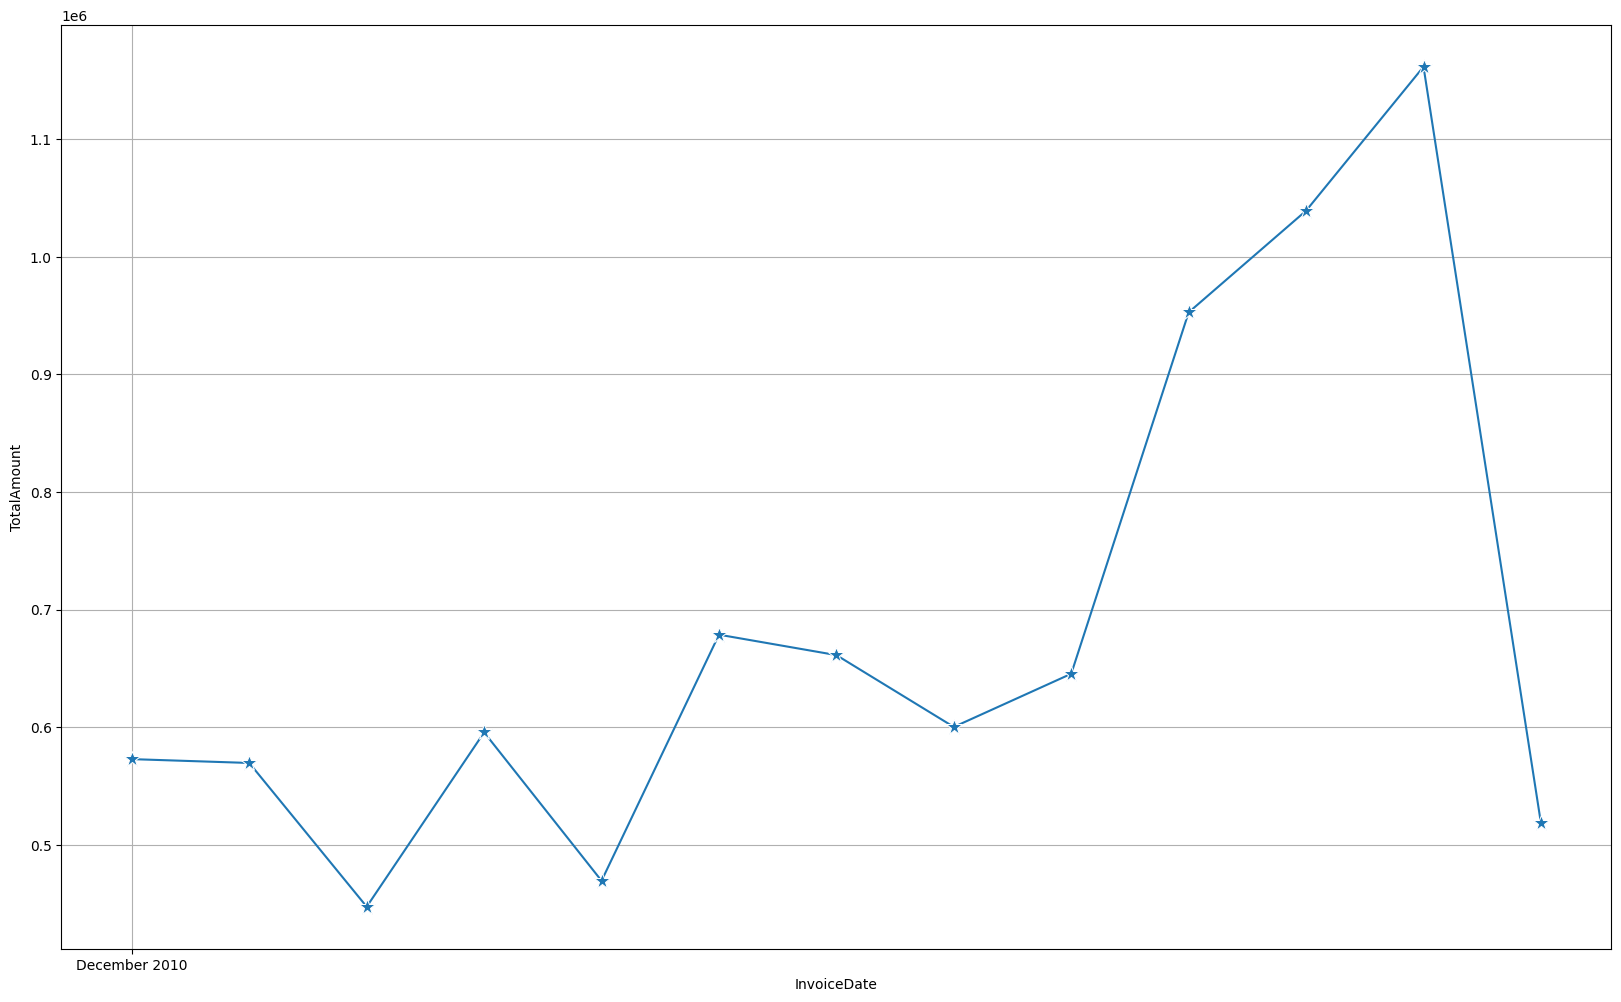

In [162]:
# create plot

# create figure
plt.figure(figsize=(20,12))
# create visualization
ax = sns.lineplot(data=by_month,
             x = by_month.index,
             y = 'TotalAmount',
             marker= '*' ,
             markersize= 12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.grid()
plt.show()

In [163]:
# Create total amount by week
by_week = df.groupby(
   by = pd.Grouper(key='InvoiceDate', freq='W')).aggregate({'TotalAmount' : 'sum'})

# Change time to week
by_week.index = by_week.index.strftime('%U %m %Y')

top_5_week = by_week.sort_values(by='TotalAmount',ascending= False).head(5).index.tolist()

print('there are top 5 week with the higher Total Amount :')
for i in (top_5_week):
    print(i)

there are top 5 week with the higher Total Amount :
50 12 2011
39 09 2011
41 10 2011
47 11 2011
46 11 2011


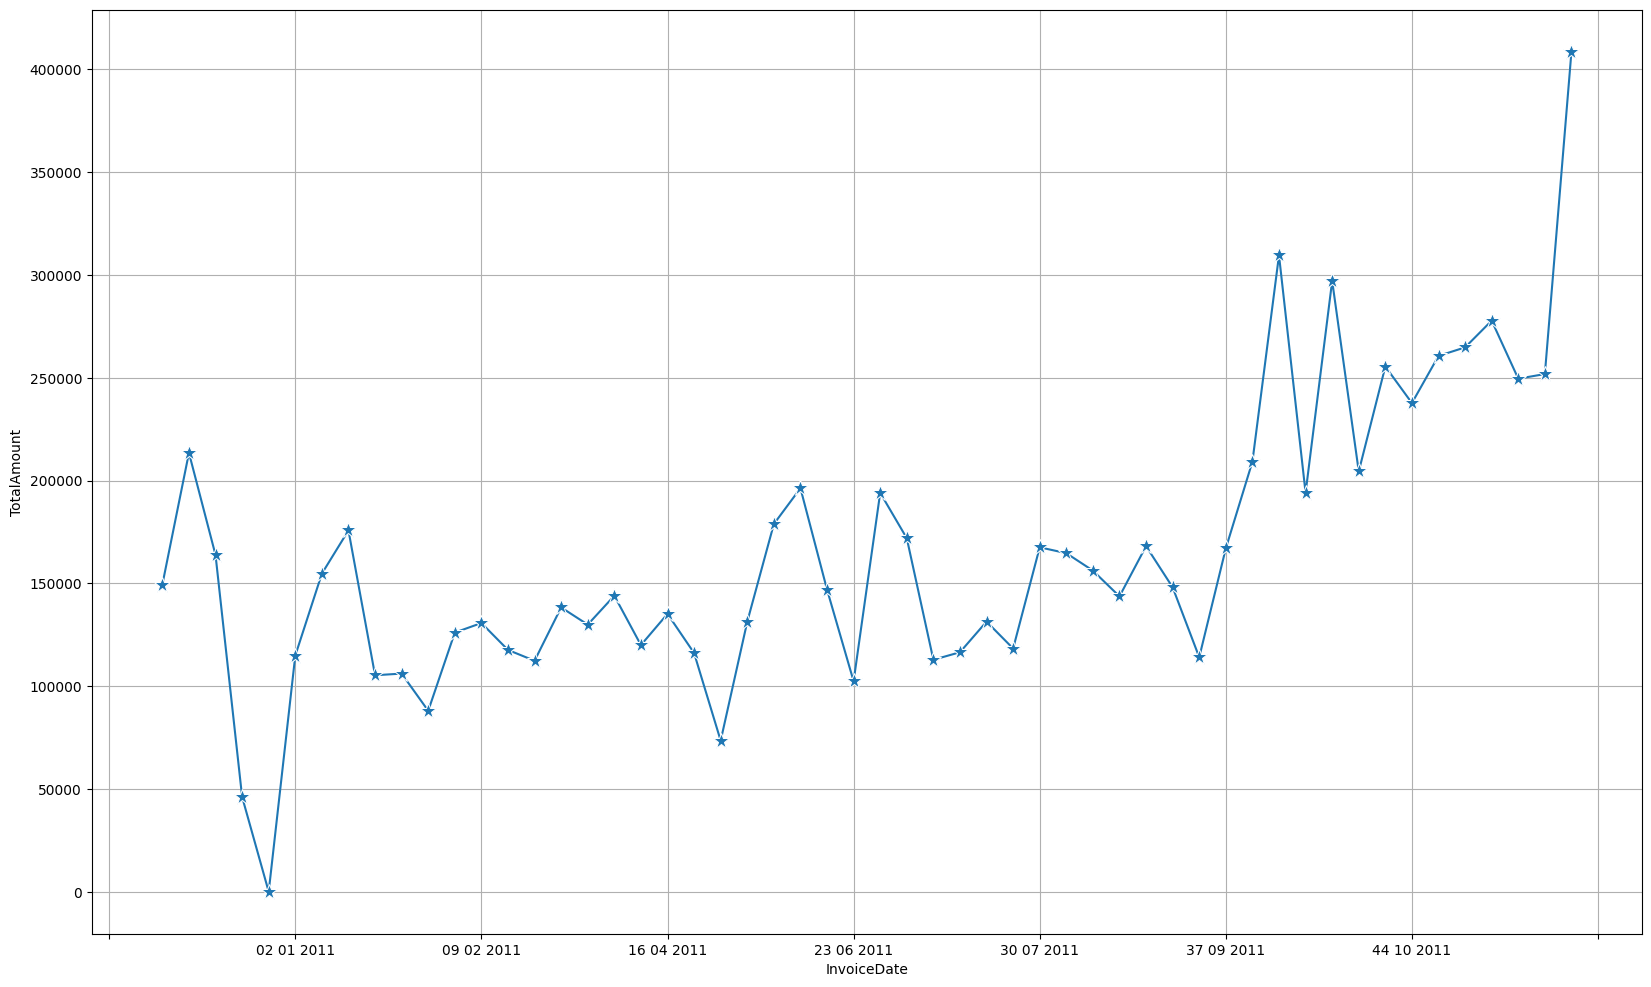

In [164]:
# create plot

# create figure
plt.figure(figsize=(20,12))
# create visualization
ax = sns.lineplot(data=by_week,
             x = by_week.index,
             y = 'TotalAmount',
             marker= '*' ,
             markersize= 12)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.grid()
plt.show()

In [165]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Country_isUK', 'TotalAmount'],
      dtype='object')

In [166]:
# Who are most valuable customer
# by Frequency
Value_Frequency = df.groupby('CustomerID')['InvoiceNo'].count()
Top_Customer_Freuqency = Value_Frequency.sort_values(ascending= False).head(5).index.tolist()

print('There are top 5 Customer by Frequency:')
for i in (Top_Customer_Freuqency):
    print(i)

There are top 5 Customer by Frequency:
17841.0
14911.0
14096.0
12748.0
14606.0


In [167]:
# Top Selling Product - by Quantity
top_selling = df.groupby('Description')['Quantity'].sum()
Top_5_Selling_Product = top_selling.sort_values(ascending=False).head(5).index.tolist()

print('There are top 5 selling product')
for i in (Top_5_Selling_Product):
    print(i)

There are top 5 selling product
PAPER CRAFT , LITTLE BIRDIE
MEDIUM CERAMIC TOP STORAGE JAR
WORLD WAR 2 GLIDERS ASSTD DESIGNS
JUMBO BAG RED RETROSPOT
WHITE HANGING HEART T-LIGHT HOLDER


# Jawaban Question 2


*Karakteristik masing-masing Cluster :*

* Cluster 0 : Merupakan kluster dengan jumlah Customer terbanyak dengan 3911 customer. Karakteristik dari customer ini adalah sudah cukup lama tidak berbelanja (High Recency), memiliki frekuensi belanja yang sedikit (Low Frequency) dan memiliki total belanja yang rendah (Low Monetary)

* Cluster 1 : Merupakan kluster dengan jumlah Customer kedua terbanyak yaitu 414 customer. Karakteristik dari customer ini adalah sudah cukup lama tidak berbelanja (High Recency), memiliki frekuensi belanja yang sedikit (Low Frequency) dan memiliki total belanja yang rendah (Low Monetary)

* Cluster 2 Merupakan kluster dengan jumlah customer paling sedikit diantara 2 cluster lain yaitu sebanyak 13 customer. Karakteristik dari customer ini adalah pernah berbelanja dalam Waktu dekat (Low Recency), memiliki frekuensi berbelanja yang tinggi (High Frequency), dan memiliki total belanja yang tinggi (High Monetary)

*Promo yang tepat bagi masing-masing cluster*

* Cluster 0 & 1 memiliki karakteristik yang mirip, kedua kelompok ini dapat diberikan promo yang sama salah satunya adalah dengan memberikan penawaran terhadap produk dengan harga rendah dengan tujuan untuk meningkatkan frekuensi kedatangan ke toko dengan harapan customer semakin terapapar dengan produk yang dijual di toko. Selain itu diharapkan juga bisa berdampak pada pembelian ke produk toko yang lain

* Sementara untuk cluster 2, promo yang dapat diberikan pada kelompok ini adalah memberikan rewards atas loyalitas yang telah diberikan. Reward dapat berupa potongan harga atau voucher. Selain reward, customer pada cluster 2 juga bisa diberikan special treatment seperti prioritas dalam pembelian atau pengantaran

# Jawaban Question 3

## Non UK Country

In [168]:
# Non_UK
# Set country to Non UK
df_nonUK = df_new[df_new['Country_UK'] == False]
df_nonUK.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12347.0,1,182,4310.00,False
12348.0,74,31,1797.24,False
12349.0,18,73,1757.55,False
12350.0,309,17,334.40,False
12352.0,35,85,2506.04,False


In [169]:
df_nonUK.describe()

,Recency,Frequency,Monetary
count,418.000000,418.000000,418.000000
mean,94.571770,104.217703,3834.967344
std,104.485451,313.632715,17626.226186
min,0.000000,1.000000,51.560000
25%,18.000000,22.000000,460.522500
50%,51.000000,45.000000,1031.995000
75%,134.500000,102.500000,2705.637500
max,373.000000,5675.000000,280206.020000


In [170]:
df_nonUK = df_nonUK.drop(columns='Country_UK')
df_nonUK.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04


In [171]:
# Scaling
scaler = StandardScaler()
df_nonUK_scaled = scaler.fit_transform(df_nonUK)

df_nonUK_scaled = pd.DataFrame(df_nonUK_scaled,
                               columns=df_nonUK.columns,
                               index=df_nonUK.index)
df_nonUK_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-0.896621,0.248302,0.026983
12348.0,-0.197122,-0.233730,-0.115746
12349.0,-0.733724,-0.099655,-0.118001
12350.0,2.054690,-0.278422,-0.198838
12352.0,-0.570827,-0.061348,-0.075485


In [172]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10] # mau berapa cluster yang dibentuk?
silhouette = []

# algoritma akan mengecek masing-masing K berdasarkan shiluette

for k in (possible_k):
    kmeans = KMeans(n_clusters=k, random_state=123).fit(df_nonUK_scaled)
    silhouette.append(silhouette_score(X = df_nonUK_scaled, labels=kmeans.labels_))

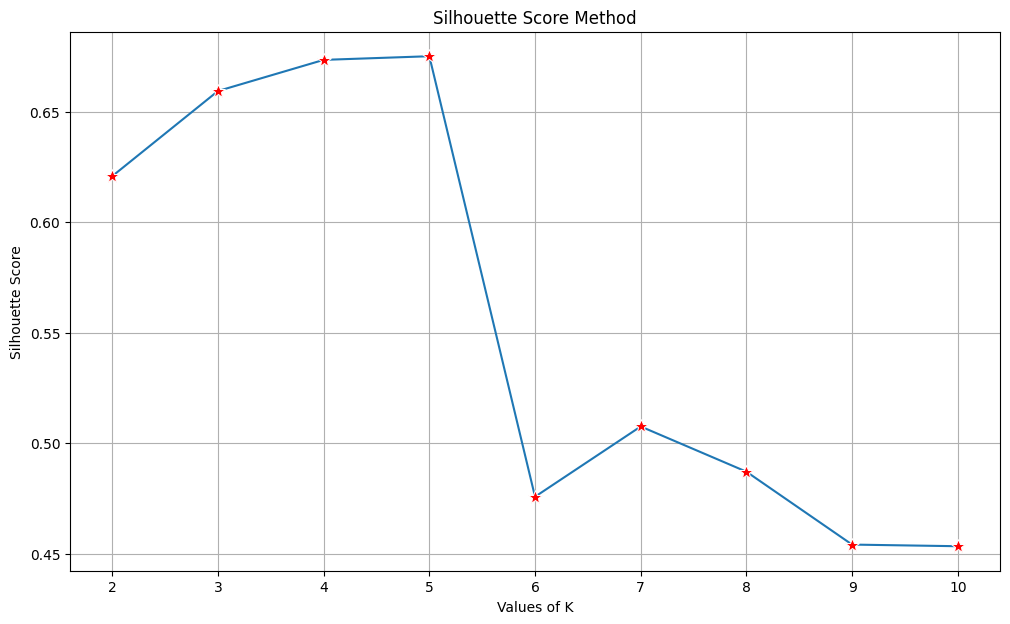

In [173]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

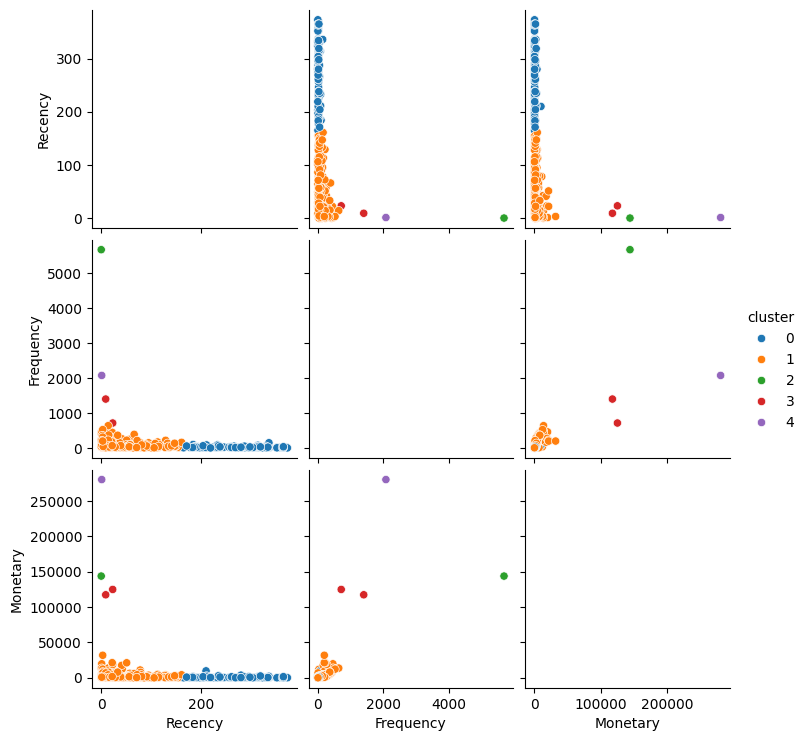

In [174]:
#Pairplot
kmeans = KMeans(n_clusters=5,random_state=123).fit(df_nonUK_scaled)

df_result_kmeans = df_nonUK.copy()
df_result_kmeans['cluster'] = kmeans.labels_
# akan dibuat kolom baru dengan nama 'cluster' dimana isinya merupakan hasil dari clustering berdasarkan K-Means

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [175]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .groupby('cluster')
    .aggregate(['count','mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                     0             1          2              3  \
Recency   count     91.000000    323.000000       1.00       2.000000   
          mean     272.582418     45.489164       0.00      16.000000   
          std       60.647445     40.554109        NaN       9.899495   
          min      162.000000      0.000000       0.00       9.000000   
          q25      222.500000     14.500000       0.00      12.500000   
          median   280.000000     31.000000       0.00      16.000000   
          q75      317.500000     71.000000       0.00      19.500000   
          max      373.000000    161.000000       0.00      23.000000   
Frequency count     91.000000    323.000000       1.00       2.000000   
          mean      25.604396     97.114551    5675.00    1057.000000   
          std       23.982345    102.991478        NaN     485.075252   
          min        1.000000      2.000000    5675.00     714.000000   
          q25       11.000000     31.000000    5675.00     885.500000   
          median    21.000000     59.000000    5675.00    1057.000000   
          q75       30.000000    125.500000    5675.00    1228.500000   
          max      149.000000    638.000000    5675.00    1400.000000   
Monetary  count     91.000000    323.000000       1.00       2.000000   
          mean     796.186593   2675.659845  143825.06  121147.080000   
          std     1201.683175   3787.829719        NaN    5327.978886   
          min       63.000000     51.560000  143825.06  117379.630000   
          q25      225.750000    611.405000  143825.06  119263.355000   
          median   433.740000   1298.040000  143825.06  121147.080000   
          q75      851.870000   3341.300000  143825.06  123030.805000   
          max     9864.260000  31906.820000  143825.06  124914.530000   

cluster                   4  
Recency   count        1.00  
          mean         1.00  
          std           NaN  
          min          1.00  
          q25          1.00  
          median       1.00  
          q75          1.00  
          max          1.00  
Frequency count        1.00  
          mean      2076.00  
          std           NaN  
          min       2076.00  
          q25       2076.00  
          median    2076.00  
          q75       2076.00  
          max       2076.00  
Monetary  count        1.00  
          mean    280206.02  
          std           NaN  
          min     280206.02  
          q25     280206.02  
          median  280206.02  
          q75     280206.02  
          max     280206.02

*Alasan Pemilihan 5 Cluster :*
* model dengan n = 5 cluster miliki nilai yang cukup tinggi jika dibandingkan dengan n yang lain
* selain itu model dengan n = 5 memiliki penurunan drastis pada n selnjutnya

*Karakteristik masing-masing Cluster :*

* Cluster 0 : Merupakan kluster dengan jumlah Customer kedua terbanyak dengan 91 customer. Karakteristik dari customer ini adalah sudah sangat lama tidak berbelanja (High Recency), memiliki frekuensi belanja yang sedikit (Low Frequency) dan memiliki total belanja yang rendah (Low Monetary)

* Cluster 1 : Merupakan kluster dengan jumlah Customer terbanyak yaitu 323 customer. Karakteristik dari customer ini adalah sudah cukup lama tidak berbelanja (High Recency), memiliki frekuensi belanja yang sedikit (Low Frequency) dan memiliki total belanja yang rendah (Low Monetary)

* Cluster 2 Merupakan kluster dengan jumlah customer hanya 1 orang. Karakteristik dari customer ini adalah pernah berbelanja dalam Waktu sangat dekat (Low Recency), memiliki frekuensi berbelanja yang sangat tinggi (High Frequency), dan memiliki total belanja yang tinggi (High Monetary)

* Cluster 3 Merupakan kluster dengan jumlah customer hanya 16 orang. Karakteristik dari customer ini adalah pernah berbelanja dalam Waktu dekat (Low Recency), memiliki frekuensi berbelanja yang tinggi (High Frequency), dan memiliki total belanja yang tinggi (High Monetary)


* Cluster 4 Merupakan kluster dengan jumlah customer hanya 1 orang. Karakteristik dari customer ini adalah pernah berbelanja dalam Waktu dekat (Low Recency), memiliki frekuensi berbelanja yang tinggi (High Frequency), dan memiliki total belanja yang sangat tinggi (High Monetary)

*Insight tambahan*

* customer dengan cluster 2,3,4 dapat dijadikan sebagai prioritas utama dalam pemberian benefit & program yang dijalankan oleh toko yang berdasarkan pada analisis RFM yang telah dilakukan

* sementara itu customer dengan cluster 0 & 1 dapat diberikan program promo harga murah dengan tujuan untuk meningkatkan frequency pembelian yang juga diharapkan dapat meningkatkan jumlah nominal belanjanya seiring berjalannya waktu
